# 📊 Round Robin Benchmark Analysis

This notebook loads the latest benchmark results from:

`src/ai/statistics/round_robin_results/*.csv`

and computes winrates, matchup charts, damage statistics, and NEAT-style metrics.

In [126]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Notebook working directory
CWD = Path().resolve()

# Walk upward until we find the project root (folder containing `src/`)
while CWD != CWD.root and not (CWD / "src").exists():
    CWD = CWD.parent

PROJECT_ROOT = CWD
print("Detected project root:", PROJECT_ROOT)

RESULTS_DIR = PROJECT_ROOT / "src/ai/statistics/round_robin_results"
print("Using results dir:", RESULTS_DIR)

csv_files = sorted(RESULTS_DIR.glob("round_robin_*.csv"))

if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {RESULTS_DIR}")

latest_csv = csv_files[-1]
print("📄 Loading:", latest_csv)

df = pd.read_csv(latest_csv)
df.head()

Detected project root: /home/cillard/projects/Game
Using results dir: /home/cillard/projects/Game/src/ai/statistics/round_robin_results
📄 Loading: /home/cillard/projects/Game/src/ai/statistics/round_robin_results/round_robin_20251209_004050.csv


,agentA,agentB,winner,turns,avg_turn_time_A,avg_turn_time_B,initial_unit_count_team1,initial_unit_count_team2,alive1,alive2,max_hp_team1,max_hp_team2,hp1,hp2
0,NEATAgent,MCTS_fast,NaN,30,0.064934,0.104870,4,4,1.0,3.0,425,320,1,66
1,NEATAgent,MCTS_deep,1.0,17,0.094441,0.344388,4,4,4.0,0.1,365,400,259,1
2,NEATAgent,MCTS_default,NaN,30,0.063671,0.218301,4,4,2.0,2.0,425,400,42,45
3,NEATAgent,Minimax_default,NaN,30,0.048588,0.277112,4,4,2.0,2.0,355,280,8,56
4,MCTS_default,NEATAgent,2.0,27,0.225739,0.065386,4,4,0.1,2.0,420,425,1,38


Agent Timing Info

In [127]:
# Convert match rows into per-agent timing rows
rows = []

for _, r in df.iterrows():
    rows.append(
        {
            "agent": r["agentA"],
            "opponent": r["agentB"],
            "avg_turn_time": r["avg_turn_time_A"],
            "role": "A",
        }
    )
    rows.append(
        {
            "agent": r["agentB"],
            "opponent": r["agentA"],
            "avg_turn_time": r["avg_turn_time_B"],
            "role": "B",
        }
    )

df_agents = pd.DataFrame(rows)
df_agents.head()

,agent,opponent,avg_turn_time,role
0,NEATAgent,MCTS_fast,0.064934,A
1,MCTS_fast,NEATAgent,0.104870,B
2,NEATAgent,MCTS_deep,0.094441,A
3,MCTS_deep,NEATAgent,0.344388,B
4,NEATAgent,MCTS_default,0.063671,A


In [128]:
agent_time = (
    df_agents.groupby("agent")["avg_turn_time"]
    .mean()
    .sort_values()
    .to_frame("mean_turn_time")
)

agent_time

,mean_turn_time
agent,
NEATAgent,0.057515
MCTS_fast,0.095008
MCTS_default,0.242921
Minimax_default,0.332767
MCTS_deep,0.362577
Minimax_wide,1.171746
Minimax_deep,1.673939


In [129]:
slowest = agent_time.tail(1)
print("🐌 Slowest Variant:")
display(slowest)

🐌 Slowest Variant:


,mean_turn_time
agent,
Minimax_deep,1.673939


In [130]:
fastest = agent_time.head(1)
print("⚡ Fastest / Most Efficient Variant:")
fastest

⚡ Fastest / Most Efficient Variant:


,mean_turn_time
agent,
NEATAgent,0.057515


Does deeper minimax explode turn time?

In [131]:
minimax_rows = agent_time[agent_time.index.str.contains("Minimax")]

print("🧠 Minimax Compute Cost Comparison:")
minimax_rows

🧠 Minimax Compute Cost Comparison:


,mean_turn_time
agent,
Minimax_default,0.332767
Minimax_wide,1.171746
Minimax_deep,1.673939


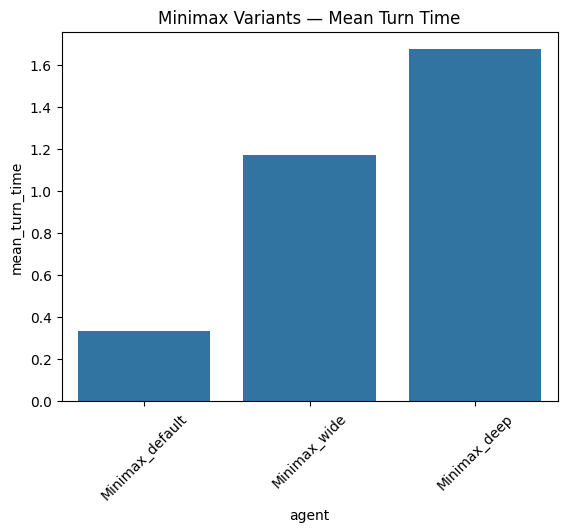

In [ ]:
# Extract rollout_turns from preset name if you encode it there, or join
# from preset file
sns.barplot(x=minimax_rows.index, y=minimax_rows["mean_turn_time"])
plt.xticks(rotation=45)
plt.title("Minimax Variants — Mean Turn Time")
plt.show()

Is MCTS rollout parameter affecting compute cost?

In [133]:
mcts_rows = agent_time[agent_time.index.str.contains("MCTS")]

print("🌲 MCTS Compute Cost Comparison:")
mcts_rows

🌲 MCTS Compute Cost Comparison:


,mean_turn_time
agent,
MCTS_fast,0.095008
MCTS_default,0.242921
MCTS_deep,0.362577


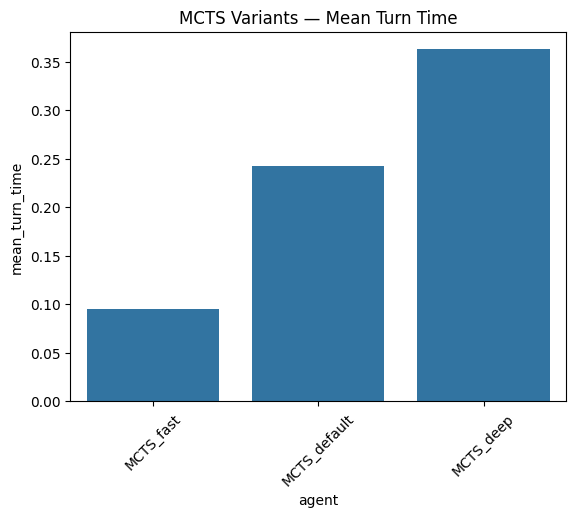

In [134]:
# Extract rollout_turns from preset name if you encode it there, or join
# from preset file
sns.barplot(x=mcts_rows.index, y=mcts_rows["mean_turn_time"])
plt.xticks(rotation=45)
plt.title("MCTS Variants — Mean Turn Time")
plt.show()

## 🧮 Winrate Summary

In [135]:
agents = sorted(set(df["agentA"]) | set(df["agentB"]))

win_stats = {a: {"wins": 0, "games": 0} for a in agents}

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]
    win_stats[A]["games"] += 1
    win_stats[B]["games"] += 1
    if winner == 1:
        win_stats[A]["wins"] += 1
    elif winner == 2:
        win_stats[B]["wins"] += 1

summary = pd.DataFrame(
    [
        {
            "agent": agent,
            "winrate": win_stats[agent]["wins"] / win_stats[agent]["games"],
            "games": win_stats[agent]["games"],
        }
        for agent in agents
    ]
).set_index("agent")

summary

,winrate,games
agent,,
MCTS_deep,0.083333,12
MCTS_default,0.083333,12
MCTS_fast,0.250000,12
Minimax_deep,0.333333,12
Minimax_default,0.166667,12
Minimax_wide,0.250000,12
NEATAgent,0.416667,12


## 🔥 Head-to-Head Winrate Matrix

In [136]:
matrix = pd.DataFrame(0.0, index=agents, columns=agents)

for _, row in df.iterrows():
    A, B, winner = row["agentA"], row["agentB"], row["winner"]
    if winner == 1:
        matrix.loc[A, B] += 1
    elif winner == 2:
        matrix.loc[B, A] += 1

games_matrix = df.groupby(["agentA", "agentB"]).size().unstack(fill_value=0)

winrate_matrix = matrix.div(games_matrix + games_matrix.T, fill_value=0)
winrate_matrix

,MCTS_deep,MCTS_default,MCTS_fast,Minimax_deep,Minimax_default,Minimax_wide,NEATAgent
MCTS_deep,NaN,0.0,0.0,0.0,0.0,0.5,0.0
MCTS_default,0.5,NaN,0.0,0.0,0.0,0.0,0.0
MCTS_fast,0.0,0.5,NaN,0.5,0.0,0.0,0.5
Minimax_deep,1.0,1.0,0.0,NaN,0.0,0.0,0.0
Minimax_default,0.0,0.0,0.5,0.5,NaN,0.0,0.0
Minimax_wide,0.0,0.0,0.5,0.0,0.5,NaN,0.5
NEATAgent,1.0,0.5,0.0,0.0,0.5,0.5,NaN


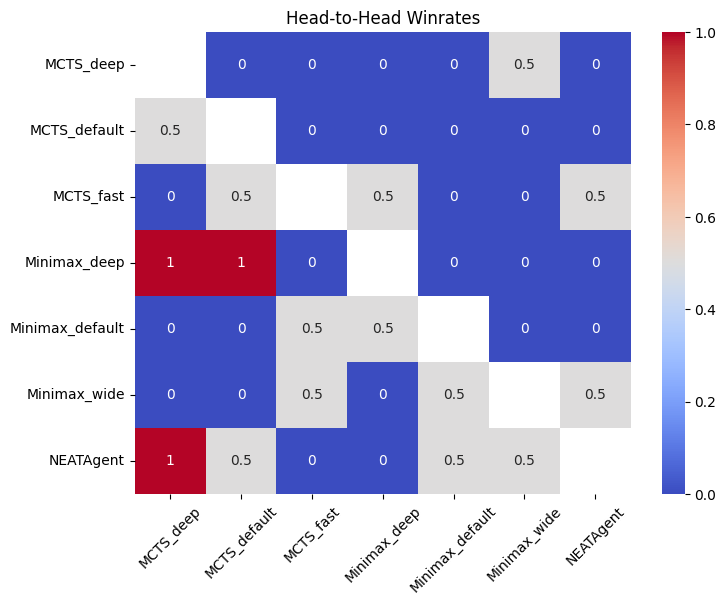

In [137]:
plt.figure(figsize=(8, 6))
sns.heatmap(winrate_matrix, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.xticks(rotation=45)
plt.title("Head-to-Head Winrates")
plt.show()

## ❤️ HP Advantage vs Win

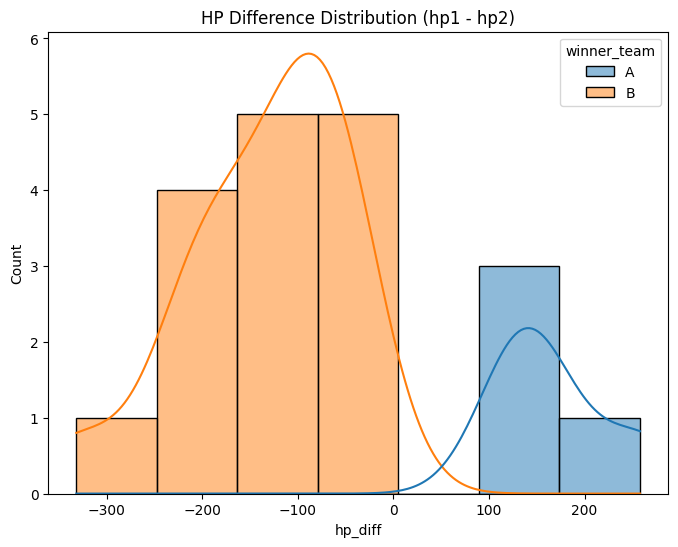

In [138]:
df["hp_diff"] = df["hp1"] - df["hp2"]
df["winner_team"] = df["winner"].map({1: "A", 2: "B"})

plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="hp_diff", hue="winner_team", kde=True)
plt.title("HP Difference Distribution (hp1 - hp2)")
plt.show()

## 🛡 Survival Analysis (Alive Units)

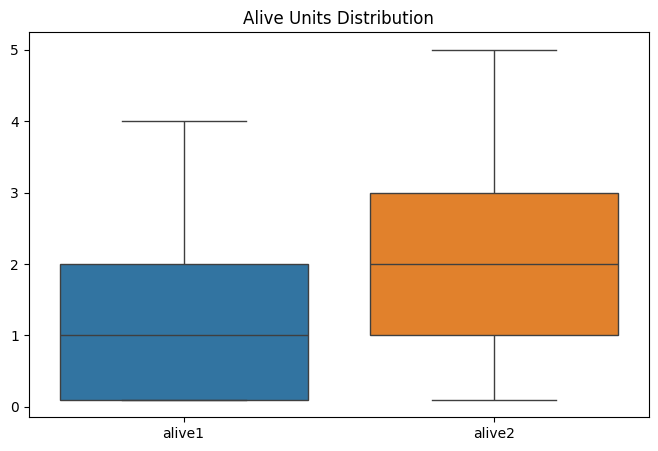

In [139]:
alive_df = df[["agentA", "agentB", "alive1", "alive2"]]
plt.figure(figsize=(8, 5))
sns.boxplot(data=df[["alive1", "alive2"]])
plt.title("Alive Units Distribution")
plt.show()

In [140]:
# Compute alive ratio per agent from stats
alive_rows = []

for _, r in df.iterrows():
    alive_rows.append(
        {
            "agent": r["agentA"],
            "alive_ratio": r["alive1"] / max(1, r["initial_unit_count_team1"]),
        }
    )
    alive_rows.append(
        {
            "agent": r["agentB"],
            "alive_ratio": r["alive2"] / max(1, r["initial_unit_count_team2"]),
        }
    )

df_alive = pd.DataFrame(alive_rows)
agent_alive = df_alive.groupby("agent")["alive_ratio"].mean().to_frame("alive_ratio")

agent_alive

,alive_ratio
agent,
MCTS_deep,0.344444
MCTS_default,0.265278
MCTS_fast,0.504167
Minimax_deep,0.529861
Minimax_default,0.427778
Minimax_wide,0.484028
NEATAgent,0.525694
